### E-08 : 인물사진 만들기 프로젝트
1. 본인 사진, 고양이 사진에 대해 셸로우 포커스 효과 주기  
2. 위 두 사진으로 크로마키  
3. 문제점 도출
4. 문제점 개선
5. 회고

### 1. 폴더 생성

In [ ]:
$ mkdir -p ~/aiffel/human_segmentation/models
$ mkdir -p ~/aiffel/human_segmentation/images

### 2. 필요 모듈 import

In [1]:
import cv2
import numpy as np
import os
import tarfile
#urllib 패키지 :  웹에서 데이터를 다운로드할 사용
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

### 3. 이미지 불러오기

In [2]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/가영.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(2871, 2877, 3)


### 4. segmentation 인물 분리하기

##### 1. DeepLabModel 클래스 생성    
구글에서 Tensorflow V1으로 작성한 DeepLab 모델 구조 활용 

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)
    #preprocess() : 전처리
    # 이미지를 전처리하여 Tensorflow 입력으로  
    #사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        #resize : 모델이 받는 입력 크기가 정해져 있음
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        #OpenCV의 디폴트 BGR 채널 ->텐서플로우에 맞는 RGB로 수정
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    # run() : 실제로 세그멘테이션을 하는 함수
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

##### 2. 사전에 학습된 가중치(pretrained weight) 불러오기  
이것도 구글에서 제공

In [4]:
#define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    #deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight 다운로드
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)
#DeepLabModel 을 초기화
MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


##### 3. 이미지 네트워크에 입력

In [5]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

#HWC(Height, Width, Channel) 
#img_orig 의 크기
#img_resized 의 크기
#세그멘테이션 맵에서 가장 큰 값(물체로 인식된 라벨 중 가장 큰 값) =16

#1에서 이미지 리사이즈랑 뭐랑 할 수있는 DeepLab 모델을 만들었음
#원본 이미지를 모델에 넣어서 리사이즈 + 세그멘테이션 등등을 함

(2871, 2877, 3) (511, 513, 3) 16


##### 4. DeepLab이 제공하는 PASCAL VOC의 라벨로 학습된 라벨 종류 확인해보기

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

#background를 제외하면 20개의 클래스 
#사람(person) 라벨=15

21

##### 5. 사람 영역 마스킹 + 시각화하기

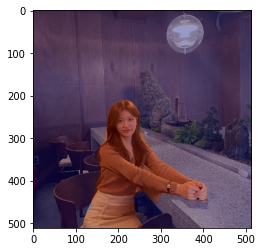

In [7]:
img_show = img_resized.copy()
#사람을 뜻하는 15 외 예측은 0으로 = # 예측 중 사람만 추출
#그럼 예측된 세그멘테이션 이미지(map)는 최댓값이 15
seg_map = np.where(seg_map == 15, 15, 0)

#일반 이미지는 0부터 255 까지의 값을 사용해 픽셀을 표현
#세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 
#255로 정규화
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
#applyColorMap(): 색 적용
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 5. 세그멘테이션 결과를 원래 크기로 복원하기  
DeepLab 모델을 사용하기 위해 이미지 크기를 작게 resize 해서 입력했음  
(2871, 2877, 3)-> (511, 513, 3)  
세그멘테이션 결과(mask)를 원래 크기로 복원

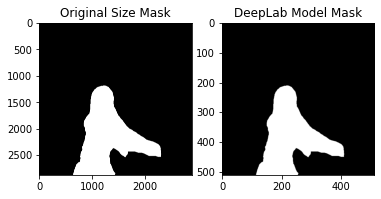

In [8]:
#cv2.resize() : 

#interpolation : 보간 (확대시킬때 고려해야함)
#이미지의 크기를 변경(scaling)하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법
# 통계적 혹은 실험적으로 구해진 데이터들(xi)로부터,
#주어진 데이터를 만족하는 근사 함수(f(x))를 구하고,
#이 식을 이용하여 주어진 변수에 대한 함수 값을 구하는 일련의 과정
#https://iskim3068.tistory.com/35
#https://opencv-python.readthedocs.io/en/latest/doc/10.imageTransformation/imageTransformation.html

# cv2.INTER_LINEAR : 정확하게 확대 (cv2.INTER_NEAREST : 깔끔하게 처리)

#img_mask_up :  경계가 블러된 픽셀값 0~255의 이미지가 됨
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
#확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(threshold)을 설정
#= 128 이하는0, 이상은 255 값을 만듦
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

### 6. 배경 흐리게 + 추출하기

##### 1. 이미지 전체 흐리게

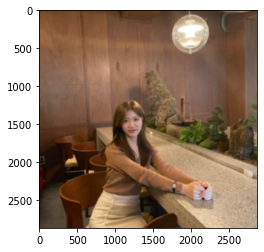

In [9]:
#blur(): 흐리게
img_orig_blur = cv2.blur(img_orig, (20,20)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

##### 2. 세그멘테이션  마스크 이용해서 배경만 추출

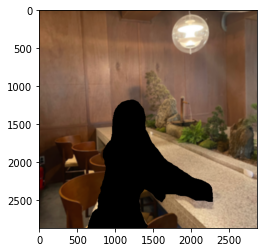

In [10]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
#bitwise_not : 이미지가 반전 (사람은0, 배경은 255)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 7.  흐린 배경과 원본 영상 합성

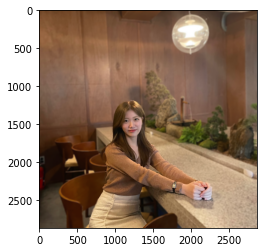

In [11]:
#세그멘테이션 마스크가 255인 부분만 원본 영상으로
#반대인 경우엔 블러된 미지 값 사용
#np,where : https://numpy.org/doc/stable/reference/generated/numpy.where.html
img_concat_me = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat_me, cv2.COLOR_BGR2RGB))
plt.show()

img_show=()

### 8. 원본, Shallow Focus 비교해보기

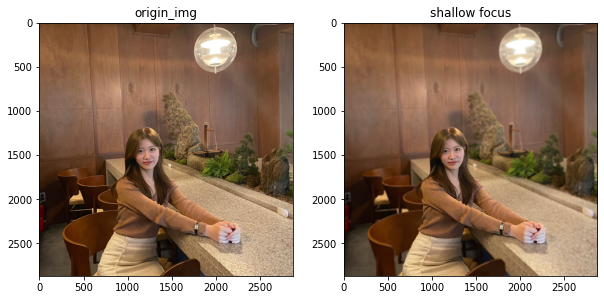

In [12]:
plt.figure(figsize=(10, 13))

ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
ax.set_title('origin_img') 

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_concat_me, cv2.COLOR_BGR2RGB))
ax.set_title('shallow focus')

plt.show()

-----
## 고양이 사진 셸로우 포커스 하기

### 1. 이미지 불러오기

In [13]:
img_path_cat = os.getenv('HOME')+'/aiffel/human_segmentation/images/고양이.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig_cat = cv2.imread(img_path_cat) 
print (img_orig_cat.shape)

(657, 620, 3)


### 2. 이미지 네트워크에 입력하기

In [14]:
img_resized_cat, seg_map_cat = MODEL.run(img_orig_cat)
print (img_orig_cat.shape, img_resized_cat.shape, seg_map_cat.max())

(657, 620, 3) (513, 484, 3) 8


### 3. 학습된 라벨 종류 확인

In [15]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

### 4. 고양이 영역 마스킹 + 시각화

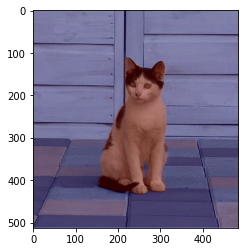

In [16]:
img_show_cat = img_resized_cat.copy()
#고양이는 라벨 8
seg_map_cat = np.where(seg_map_cat == 8, 8, 0)

#일반 이미지는 0부터 255 까지의 값을 사용해 픽셀을 표현
#세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 
#255로 정규화
img_mask_cat = seg_map_cat * (255/seg_map_cat.max())
img_mask_cat = img_mask_cat.astype(np.uint8)
#applyColorMap(): 색 적용
color_mask = cv2.applyColorMap(img_mask_cat, cv2.COLORMAP_JET)
img_show_cat = cv2.addWeighted(img_show_cat, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show_cat, cv2.COLOR_BGR2RGB))
plt.show()

### 5. 이미지 사이즈 복원하기

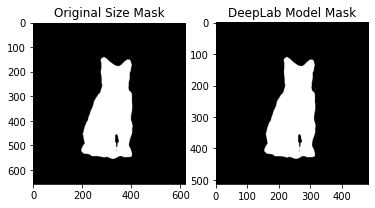

In [17]:
#img_mask_up :  경계가 블러된 픽셀값 0~255의 이미지가 됨
img_mask_up_cat = cv2.resize(img_mask_cat, img_orig_cat.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
#확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(threshold)을 설정
#= 128 이하는0, 이상은 255 값을 만듦
_, img_mask_up_cat = cv2.threshold(img_mask_up_cat, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up_cat, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask_cat, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

### 6. 배경 흐리게 + 추출

##### 1. 이미지 전체 흐리게

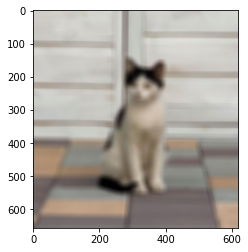

In [18]:
#blur(): 흐리게
img_orig_cat_blur = cv2.blur(img_orig_cat, (20,20)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_cat_blur, cv2.COLOR_BGR2RGB))
plt.show()

##### 2. 흐리게한 배경만 segmentation mask로 추출

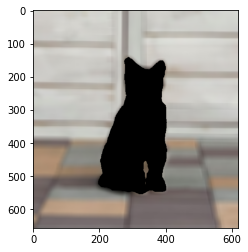

In [19]:
img_mask_color_cat = cv2.cvtColor(img_mask_up_cat, cv2.COLOR_GRAY2BGR)
#bitwise_not : 이미지가 반전 (사람은0, 배경은 255)
img_bg_mask_cat = cv2.bitwise_not(img_mask_color_cat)
img_bg_blur_cat = cv2.bitwise_and(img_orig_cat_blur, img_bg_mask_cat)
plt.imshow(cv2.cvtColor(img_bg_blur_cat, cv2.COLOR_BGR2RGB))
plt.show()

### 7. 흐린배경 고양이 이미지 합치기

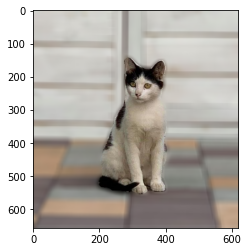

In [20]:
#세그멘테이션 마스크가 255인 부분만 원본 영상으로
#반대인 경우엔 블러된 미지 값 사용
#np,where : https://numpy.org/doc/stable/reference/generated/numpy.where.html
img_concat_cat = np.where(img_mask_color_cat==255, img_orig_cat, img_bg_blur_cat)
plt.imshow(cv2.cvtColor(img_concat_cat, cv2.COLOR_BGR2RGB))
plt.show()

img_show=()

### 8. 원본, shallow focus 이미지 비교

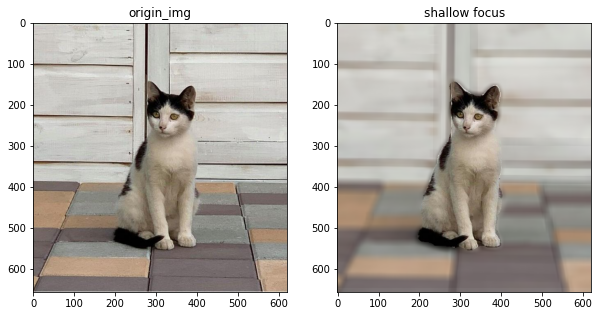

In [21]:
plt.figure(figsize=(10, 13))

ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_orig_cat, cv2.COLOR_BGR2RGB))
ax.set_title('origin_img') 

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_concat_cat, cv2.COLOR_BGR2RGB))
ax.set_title('shallow focus')

plt.show()

-----
## 위 두 이미지로 크로마키 해보기

### 1. 배경, 이미지, 이미지 mask 리사이즈

In [22]:
# 이미지, 배경사진, 이미지 mask 리사이즈
cat_resized = cv2.resize(img_orig_cat, (img_concat_me.shape[1], img_concat_me.shape[0]))
concat_me_resized = cv2.resize(img_concat_me, (img_concat_me.shape[1], img_concat_me.shape[0]))

cat_img_mask_resized = cv2.resize(img_mask_color_cat, (img_concat_me.shape[1], img_concat_me.shape[0]))

print(cat_resized.shape)
print(concat_me_resized.shape)
print(cat_img_mask_resized.shape)

(2871, 2877, 3)
(2871, 2877, 3)
(2871, 2877, 3)


### 2. 배경 + 이미지 합치기

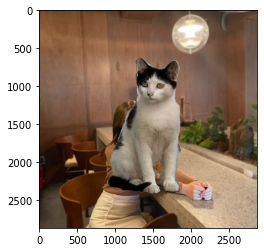

In [23]:
# 배경 영상과 고양이 영상을 합치기
cat_me_concat = np.where(cat_img_mask_resized == 255, cat_resized, concat_me_resized)

plt.imshow(cv2.cvtColor(cat_me_concat, cv2.COLOR_BGR2RGB))
plt.show()

-----
## 문제점

**1.인물의 경계선 처리**  
그림자 부분도 인물이라고 인식하고있다.  
경계선이 부드럽게 깔끔히 처리가 되지 않고 있다  
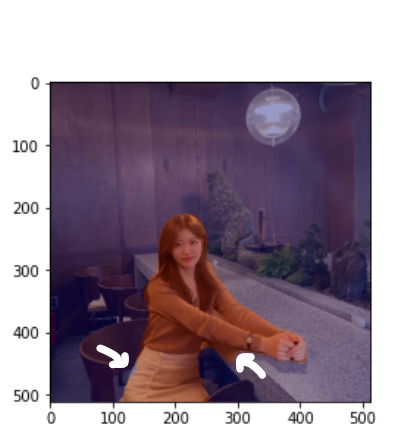

**2.고양이 리사이즈, 위치**  
고양이의 사이즈와 위치가 재고려 되어야한다  
나의 의도는 내 팔 옆에 고양이가 잘 앉아있는 것이다. 
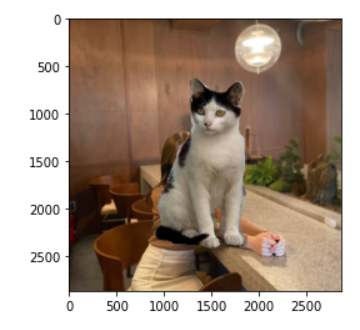

-----
## 문제점 해결

### 1. 인물의 경계선 인식 개선_CRF
https://m.blog.naver.com/laonple/221017461464
http://swoh.web.engr.illinois.edu/courses/IE598/handout/fall2016_slide15.pdf

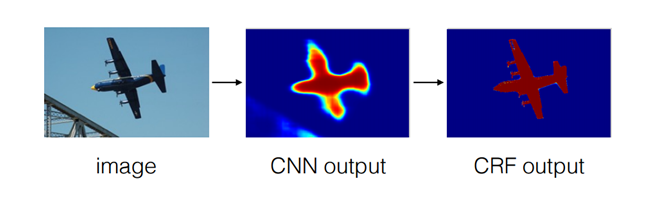
시멘틱 세그멘테이션은 픽셀 단위 조밀한 예측 필요  
classfication 망을 기반으로 -> segmentation 망 구성시에 feature map 크기 줄어듦  
때문에 디테일한 정보 얻기 힘듦  

##### 디테일한 정보를 위한 해결책
- **FCN** 에서  
  **skip connection layer**을 사용  

- detailed convlution 이나 **DeepLab** 에서  
  마지막에 오는 pooling layer 2개 대신 **dilated(atrous) convolution** 사용  

- 그래도 한계가 존재하기 때문에  
  **후처리** 과정에 **CRF(conditional random field)** 사용  
  픽셀 단위 예측의 정확도 높일 수 있음  

##### short-range CRF
일반적으로 좁은 범위 CRF = short-range CRF  
세그멘테이션 수행 후 생기는 잡음 없애는 용도로 사용되었음  
하지만 DCNN에서는 conv+pooling 으로 크기 작아지고  
다시 원래 사이즈로 upsampling 하기 때문에 충분히 부드러운 상태임  
여기다가 short-range CRF를 하면 결과가 더 나빠짐  


##### Fully Connected CRF  
이후 스탠포드대에서 논문 발표  
Efficient Inference in Fully Connected CRFs with Gaussian Edge Potentials  
전체 픽셀을 모두 연결한 CRF 방법  

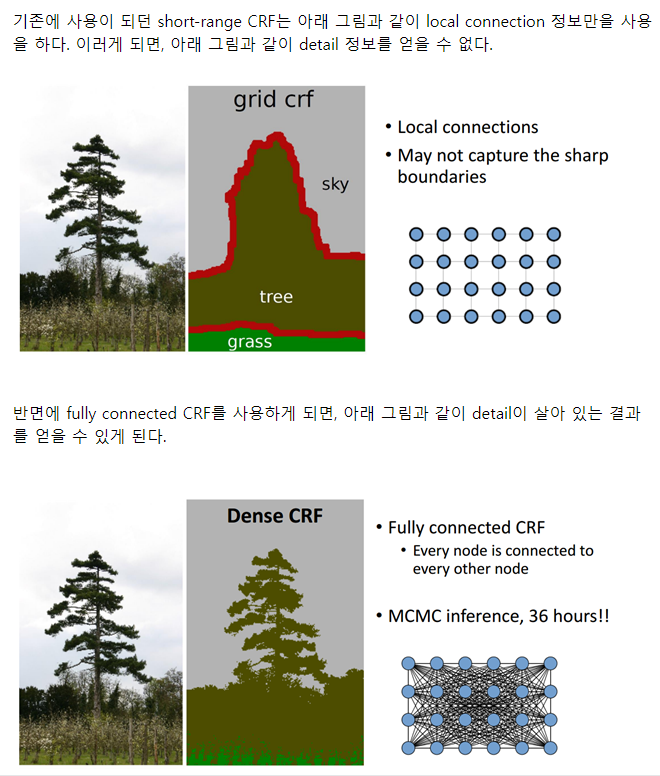

CRF 수식 확인해보면, 2개의 가우시안 커널이 구성됨  
첫번째 가우시안 커널 : 비슷한 위치/컬러 갖는 픽셀들이 비슷한 라벨 붙을 수 있도록   
두번째 가우시안 커널 : 원래 픽셀 접근도에 따라 smooth 수준을 결정함   
이것을 고속 처리하기 위해 : 위 논문에 나온 방법 사용  

In [27]:
# 실제 코드 구현은 못함

### 2. 고양이 리사이즈 + 위치 수정
EX_03 고양이 수염 노드 참고

(1000, 850, 3)


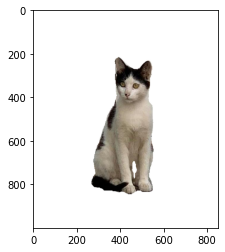

In [24]:
# 고양이 사진 추출 및 리사이즈
cat = np.where(img_mask_color_cat==255, img_orig_cat, 255)
cat = cv2.resize(cat, dsize=(850, 1000), interpolation=cv2.INTER_CUBIC)

print(cat.shape)
plt.imshow(cv2.cvtColor(cat, cv2.COLOR_BGR2RGB))
plt.show()

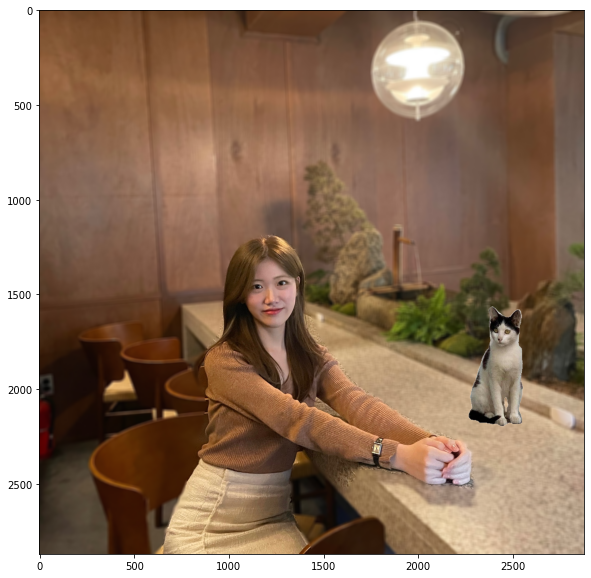

In [25]:
# 리사이즈 사진 위치지정 + 배경과 합성하기
refined_y = 1350
refined_x = 2000

sticker_area = concat_me_resized[refined_y:refined_y+cat.shape[0], refined_x:refined_x+cat.shape[1]]
concat_me_resized[refined_y:refined_y+cat.shape[0], refined_x:refined_x+cat.shape[1]] = np.where(cat==255,sticker_area,cat).astype(np.uint8)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(concat_me_resized, cv2.COLOR_BGR2RGB))
#plt.axis('off')
plt.show()

-----
## 그 외 도전_ 가우시안 블러링
가우시안 커널 경험 위해

가우시안 블러링  = 정규분포에 따른 블러링  
https://hyongdoc.tistory.com/411

1. 개념  
가우시안 분포를 갖는 커널로 블러링을 적용한 것  
가우시안 분포 함수가 종 형태를 이루듯,  
커널 가운데 값이 가장 크고 + 중앙에서 멀수록 값이 작음  
<br>

2. 적용 코드 (2가지 방법 존재)  
1) 가우시안 커널 생성 코드  
cv2.getGaussianKernel(커널 크기,표준편차) 

  - 커널만 생성하는 함수
  - 가우시안 커널의 return 값 = 1차원 배열  
    cv2.filter2D() 함수 적용 위해서는  
    커널과 커널의 전치행렬 곱한 값 인자로 사용해야함  
  - 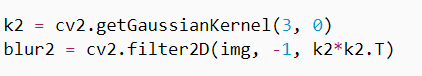
2) 가우시안 블러링 적용 코드  
cv2.GaussianBlur(입력 영상, 커널 크기, x 방향 표준편차, [y방향 표준편차,경계 보정 방법])  
  - GaussianBlur(src, ksize, sigmaX)
  - 이미지에 가우시안 처리까지 한방에 해결하는 코드  
  - 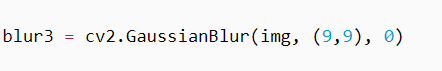

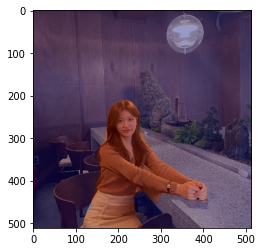

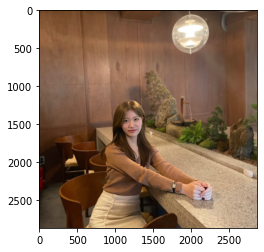

In [26]:
#1. 인물 원본 이미지 가져오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/가영.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 

#2. 준비한 이미지 네트워크에 입력
img_resized, seg_map = MODEL.run(img_orig)

#3. 인물 영역 마스킹
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

#4. 모델에서 resize 했던것 원래 크기로 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

#이 아래부터 부분 우수노드 참고 (계속 오류남 ㅠㅠㅠ)

#5. img_mask_up의 채널을 원본 사진과 맞게 3 channel로 바꿈
img_mask_3C = np.repeat(np.expand_dims(img_mask_up, axis=2), 3, axis=2).astype(np.uint8)

#6. 인물이미지 가우시안 블러링
img_orig_Gb = cv2.GaussianBlur(img_orig, (25,25), 0)

#7. 마스킹 이미지 가우시안 블러링
img_Gmask = (cv2.GaussianBlur(img_mask_3C, (101, 101), 25, 25)/255).astype(np.float32)

#8. 마스크와 이미지 더해줌
image_blur = img_Gmask*img_orig.astype(np.float32)

#9. 마스크를 해줘서 Blur 처리한 원본에서 배경만 뽑아냄
img_bg_mask = (1-img_Gmask)*img_orig_Gb.astype(np.float32)
img_output2 = (image_blur+img_bg_mask).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_output2, cv2.COLOR_BGR2RGB))
plt.show()

## 회고

💚**루브릭**
1. 인물모드 사진을 성공적으로 제작하였다.  
아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진,  
배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작함
<br>

2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.  
인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출함  
<br>

3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.  
1) fully connected CRF를 제시  
2) 고양이 마스킹 이미지 리사이즈 + 사진 위치 지정함  

💚**어려웠던점**  
시멘틱 세그멘테이션에 대한 개념을 공부하면서  
흐름을 따라 구현해내보고, 반복 구현 하면서  
어느정도 익숙해짐  
하지만 아직 코드 by 코드로 모두 이해하지는 못했음  

💚**이후 개선하고 싶은 점**  
fully connected CRF에 대한 논문을 깊게 이해하고,  
해당 기술을 직접 구현해보고 싶음   